# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
pwd

'/home/jovyan/tcs-dl-batch1/Week7-RCNN/Mask_RCNN-master'

In [2]:
ROOT_DIR = '/home/jovyan/tcs-dl-batch1/Week7-RCNN/Mask_RCNN-master'#'/home/jovyan/Mask_RCNN-master'

In [3]:
!pip install scikit-image

  Using cached https://files.pythonhosted.org/packages/24/06/d560630eb9e36d90d69fe57d9ff762d8f501664ce478b8a0ae132b3c3008/scikit_image-0.14.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7c/2b/cf9e5477bec3bd3b4687719876ea38e9d8c9dc9d3526365c74e836e6a650/dask-1.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/85/5e/e91792f198bbc5a0d7d3055ad552bc4062942d27eaf75c3e2783cf64eae5/Pillow-5.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fe/68/74a8527b3a727aa69736baaf5a273d83947fa6c91ef4f2e1efddda00d8b6/PyWavelets-1.0.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/34/80/66d06012248d7a8d3caf8c52937d435371336fb1161eb919ff6a57dccc70/cloudpickle-0.7.0-py2.py3-none-any.whl
You are using pip version 9.0.3, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLOON_WEIGHTS_PATH = 'mask_rcnn_balloon.h5' 

Using TensorFlow backend.


In [5]:
from samples.balloon import balloon

## Configurations

In [6]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

## TRAIN MODEL - USE PRETRAINED COCO WEIGHTS

In [7]:
!python3 balloon.py train --dataset='/content/gdrive/My Drive/Mask_RCNN-master/datasets/balloon' --weights=coco

python3: can't open file 'balloon.py': [Errno 2] No such file or directory


## LOAD CONFIGURATIONS


In [8]:
# THIS CELL LOADS CONFIGURATIONS AND NOTEBOOK PREPARATIONS TO PREPARE FOR INFERENCE. DO NOT EDIT THIS CELL. SIMPLY RUN IT. 

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## LOAD VALIDATION DATA


In [10]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 13
Classes: ['BG', 'balloon']


## Load Model and Weights

In [11]:
! wget https://videokenoffshore.blob.core.windows.net/videoken-public-data/mask_rcnn_balloon.h5


--2019-02-12 06:57:51--  https://videokenoffshore.blob.core.windows.net/videoken-public-data/mask_rcnn_balloon.h5
Resolving videokenoffshore.blob.core.windows.net (videokenoffshore.blob.core.windows.net)... 52.191.176.36
Connecting to videokenoffshore.blob.core.windows.net (videokenoffshore.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255858144 (244M) [application/octet-stream]
Saving to: ‘mask_rcnn_balloon.h5.1’

mask_rcnn_balloon.h 100%[===================>] 244.00M   101MB/s    in 2.4s    

2019-02-12 06:57:54 (101 MB/s) - ‘mask_rcnn_balloon.h5.1’ saved [255858144/255858144]



## RUN DETECTION

In [14]:
'''

Task 1 a): Load model to prepare for inference. Explore mrcnn.model directory to find:
         
        a) Which function to use
        b) What parameters to pass

'''
from mrcnn.model import data_generator,MaskRCNN
with tf.device(DEVICE):
    # YOUR CODE HERE
    data_generator(dataset,config)
    maskrcnn=MaskRCNN('inference',config,MODEL_DIR)
    
  
  
  

In [15]:
maskrcnn.load_weights( 'mask_rcnn_balloon.h5', by_name=True, exclude=None)

image ID: balloon.16335852991_f55de7958d_k.jpg (1) /home/jovyan/tcs-dl-batch1/Week7-RCNN/Mask_RCNN-master/datasets/balloon/val/16335852991_f55de7958d_k.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (7,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (7, 4)                min:   85.00000  max:  624.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


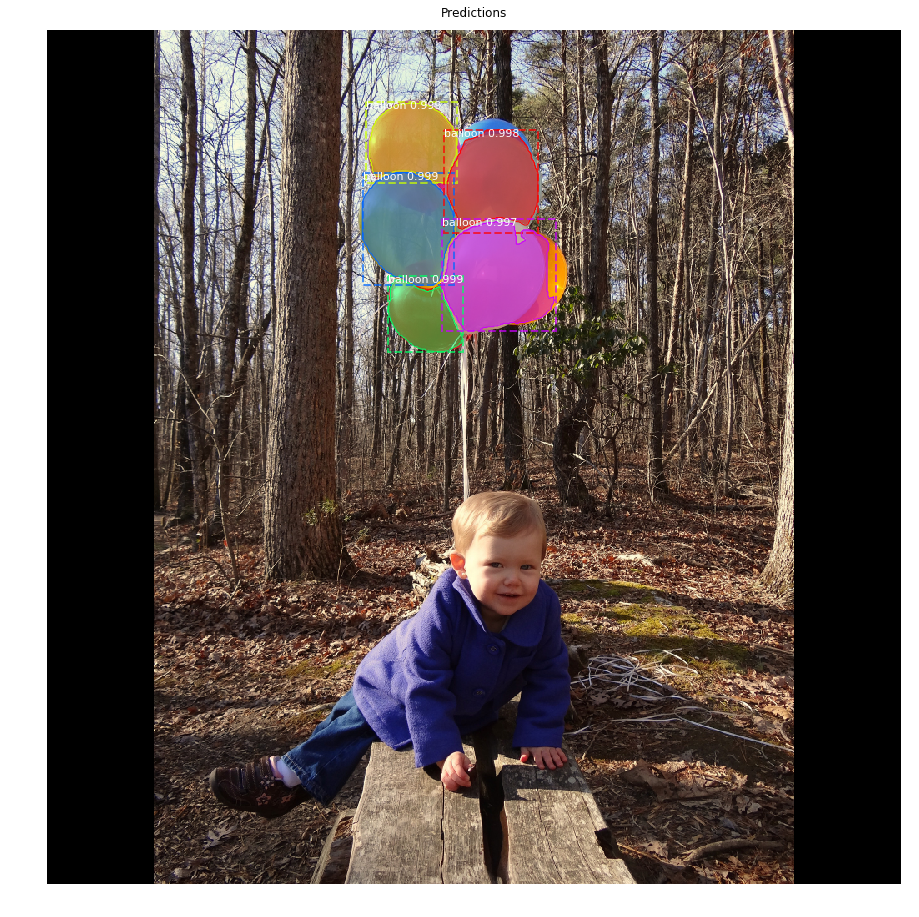

In [16]:
# RUN THIS CELL TO VIEW INFERENCE RESULTS
model = maskrcnn
image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = maskrcnn.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [17]:
! wget https://videokenoffshore.blob.core.windows.net/videoken-public-data/deeplab_model.tar.gz

--2019-02-12 07:01:07--  https://videokenoffshore.blob.core.windows.net/videoken-public-data/deeplab_model.tar.gz
Resolving videokenoffshore.blob.core.windows.net (videokenoffshore.blob.core.windows.net)... 52.191.176.36
Connecting to videokenoffshore.blob.core.windows.net (videokenoffshore.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460058541 (439M) [application/octet-stream]
Saving to: ‘deeplab_model.tar.gz.1’

deeplab_model.tar.g 100%[===================>] 438.75M   115MB/s    in 3.9s    

2019-02-12 07:01:11 (112 MB/s) - ‘deeplab_model.tar.gz.1’ saved [460058541/460058541]



NameError: name 'DeepLabModel' is not defined

In [59]:
import get_dataset_colormap

ModuleNotFoundError: No module named 'get_dataset_colormap'

In [53]:
image_path = os.path.join(ROOT_DIR, "datasets/person.jpg")
from PIL import Image
orignal_im = Image.open(image_path)
resized_im, seg_map = model.run(orignal_im)

In [88]:
seg_map

AttributeError: 'numpy.ndarray' object has no attribute 'attrs'

In [60]:
from matplotlib import gridspec
from matplotlib import pyplot as plt

def vis_segmentation(image, seg_map):
    plt.figure(figsize=(20, 20))
    grid_spec = gridspec.GridSpec(2, 2)
    
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
        
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    
    plt.subplot(grid_spec[1])
    seg_image = Image.fromarray(np.uint8(seg_image))            
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
#    return output_image
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)

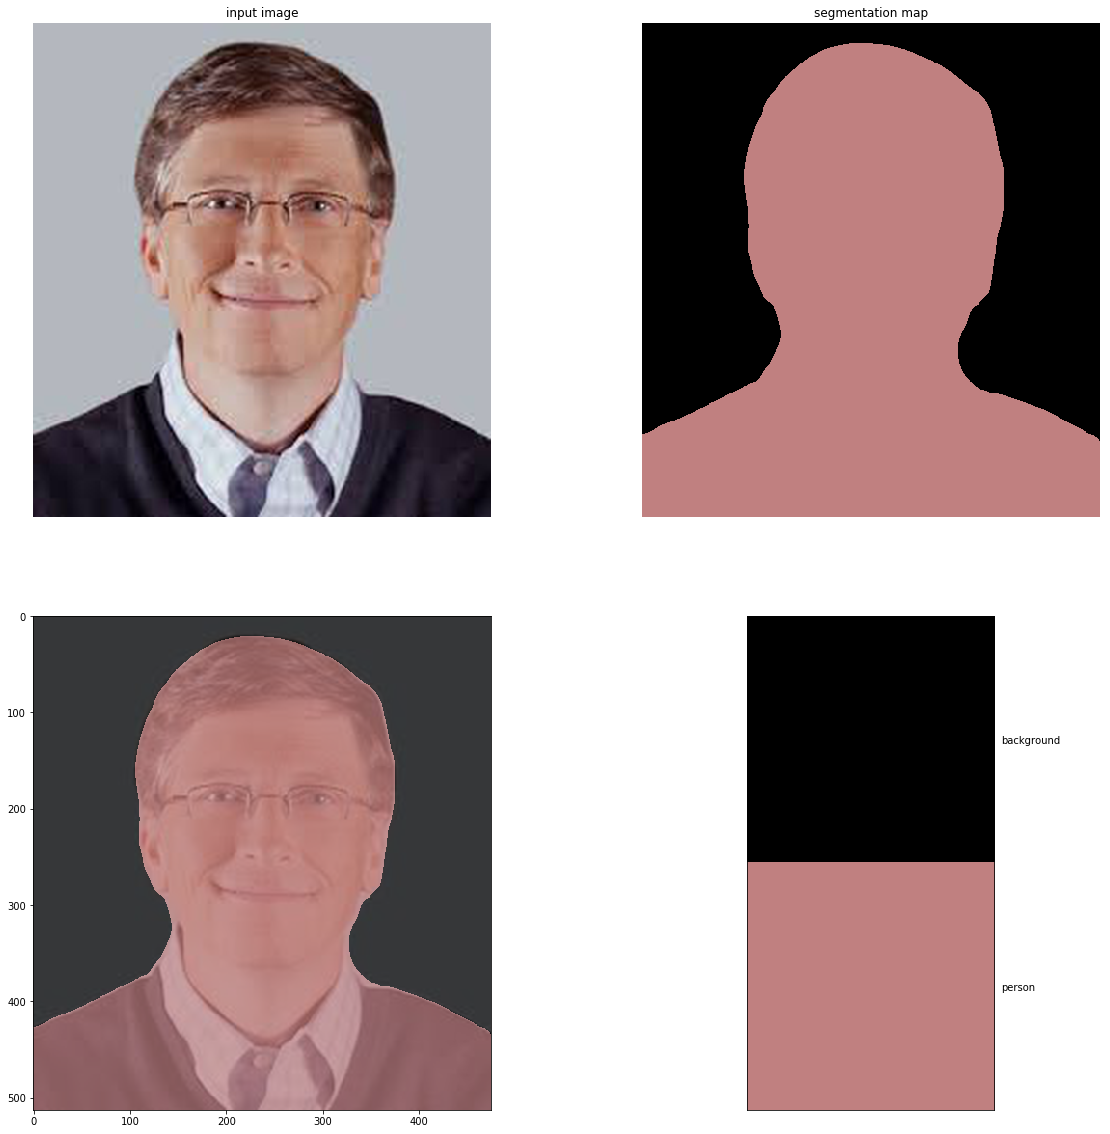

In [63]:
import get_dataset_colormap
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)
vis_segmentation(resized_im, seg_map)

In [72]:
def save_annotation(label,
                    save_dir,
                    filename,
                    add_colormap=True,
                    colormap_type=get_dataset_colormap.get_pascal_name()):
  """Saves the given label to image on disk.

  Args:
    label: The numpy array to be saved. The data will be converted
      to uint8 and saved as png image.
    save_dir: The directory to which the results will be saved.
    filename: The image filename.
    add_colormap: Add color map to the label or not.
    colormap_type: Colormap type for visualization.
  """
  # Add colormap for visualizing the prediction.
  if add_colormap:
    colored_label = get_dataset_colormap.label_to_color_image(
        label, colormap_type)
  else:
    colored_label = label

  pil_image = Image.fromarray(colored_label.astype(dtype=np.uint8))
  with tf.gfile.Open('%s/%s.png' % (save_dir, filename), mode='w') as f:
    pil_image.save(f, 'PNG')

In [73]:
save_annotation(seg_map,
                    os.path.join(ROOT_DIR, "datasets"),
                    'via_Per_region_data.json',
                    add_colormap=True,
                    colormap_type=get_dataset_colormap.get_pascal_name())

In [40]:
'''

Task 2:

Run inference on 3 other unique images. 

'''

#YOUR CODE HERE

'\n\nTask 2:\n\nRun inference on 3 other unique images. \n\n'

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

In [0]:
'''

Task :

Something fun. Explore balloon.py file and look for the color_splash function. 
Pass in the parameters required to view to results.

'''

#COMPLETE THE LINE BELOW
splash = 

#DISPLAY RESULT
display_images([splash], cols = 1)

# Congrats. You have reached the end! 